## Implement a 2D Convolutional Neural Network (CNN) similar to LeNet-5

## Lenet-5 (http://yann.lecun.com/exdb/lenet/)
    """
    LetNet-5 (modified)
    Input - 32x32
    C1 - 6@28x28 (5x5 kernel)
    tanh
    S2 - 6@14x14 (2x2 kernel, stride 2) Subsampling
    C3 - 16@10x10 (5x5 kernel, stride 1)
    tanh
    S4 - 16@5x5 (2x2 kernel, stride 2) Subsampling
    C5 - 120@1x1 (5x5 kernel)
    F6 - 84
    tanh
    F7 - 10 (Output)
    """

In [1]:
#select GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist

fix the seeds of random number generators, so the result will be reproducible (almost)

In [3]:
#https://pytorch.org/docs/stable/notes/randomness.html
#https://pytorch.org/docs/stable/cuda.html
import random
random.seed(0)
np.random.seed(0)

### Define the network

In [4]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=120, kernel_size=(5,5), strides=(1,1), padding='valid', activation = 'relu'))
model.add(Flatten())
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=10,  activation='softmax'))
optimizer=SGD(lr=1, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 120)         48120     
                                                                 
 flatten (Flatten)           (None, 120)               0

In [5]:
#It is difficult to manually adjust learnig rate in keras
#this is a solution that creates a new optimizer with a new learning rate
#this solutoin is useful if you want to reduce learning rate every 10 (or 100) epochs
#but it cannot be used to implement a sine-wave learning rate scheduling function
#you may need https://keras.io/callbacks/#learningratescheduler
optimizer=SGD(lr=0.01, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Load data

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
#normalization
x_train/=255 
x_test/=255

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
x_train.max()

1.0

### Resize the images from 28x28 to 32x32

In [9]:
from skimage.transform import resize
x_train_resized=np.zeros((x_train.shape[0],32,32), dtype=np.float32)
for n in range(0, x_train.shape[0]):
    x = x_train[n,:,:]
    x = resize(x, [32, 32], mode='edge')
    x_train_resized[n,:,:]=x
x_test_resized=np.zeros((x_test.shape[0],32,32), dtype=np.float32)
for n in range(0, x_test.shape[0]):
    x = x_test[n,:,:]
    x = resize(x, [32, 32], mode='edge')
    x_test_resized[n,:,:]=x
x_train=x_train_resized
x_test=x_test_resized

### Reshape every data point
The size of the input tensor is (N, H, W, C),  C=1, H=W=32

In [10]:
x_train=x_train.reshape(-1,32,32,1)
x_test=x_test.reshape(-1,32,32,1)

### create a validation set

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)
print('train:', x_train.shape, y_train.shape)
print('validation:', x_val.shape, y_val.shape)
print('test:', x_test.shape, y_test.shape)

train: (54000, 32, 32, 1) (54000,)
validation: (6000, 32, 32, 1) (6000,)
test: (10000, 32, 32, 1) (10000,)


### show the images

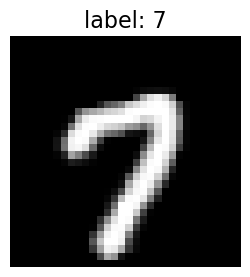

<Figure size 640x480 with 0 Axes>

In [12]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, x_train.shape[0], 5000):
    I = x_train[n].reshape(32,32)
    ax.imshow(I, cmap='gray')
    ax.set_title('label: ' + str(int(y_train[n])), fontsize=16)
    ax.axis('off')
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.1) 

In [13]:
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list,
                loss_test_list, acc_test_list):    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].plot(loss_test_list, '-r', label='testing loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    #ax[0].set_xticks(np.arange(len(loss_train_list)))
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].plot(acc_test_list, '-r', label='testing accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    #ax[1].set_xticks(np.arange(len(loss_train_list)))
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

### train the neural network model over many epochs

In [14]:
#manually adjust the learning rate during training
# set_lr(optimizer, 0.01)
#lr: 1  too large
#lr: 0.1 too large
#lr: 0.01 - reduce lr -> 0.005 -> reduce lr - 0.001

In [15]:
#run this whenever creating a new model
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
loss_test_list=[]
acc_test_list=[]
epoch_save=-1

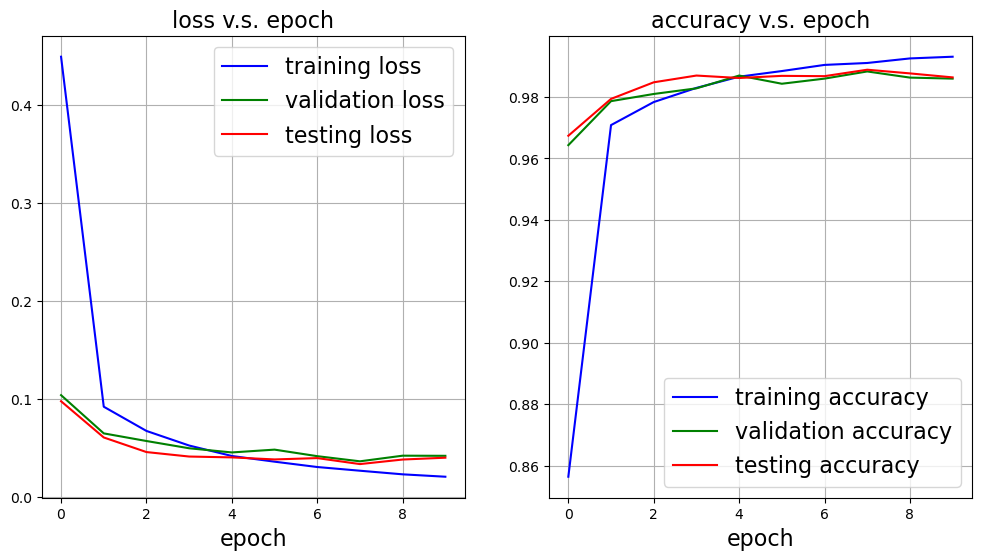

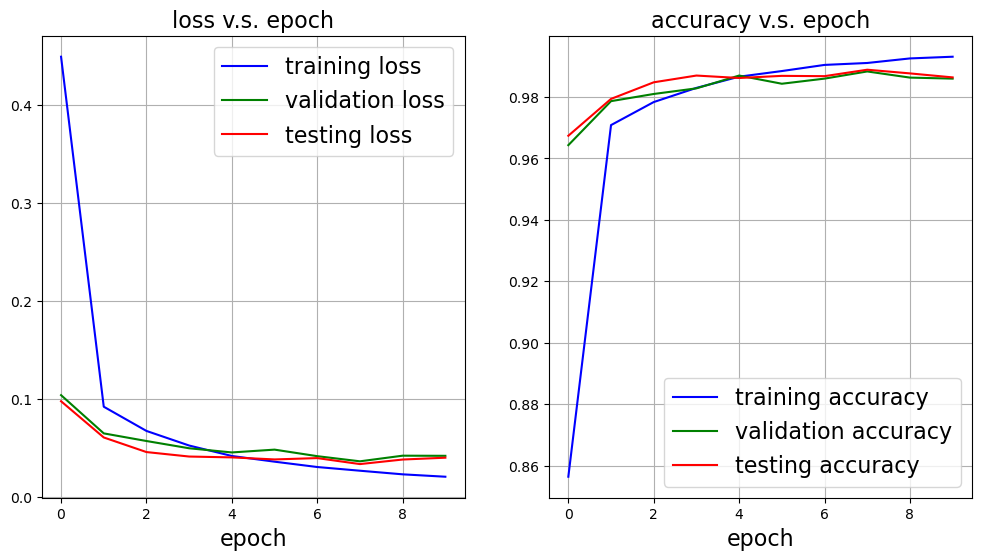

In [16]:
for epoch in range(epoch_save+1, 10):
    #-------- training and validation--------------------------------
    print('epoch', epoch)
    #set epochs=1
    history=model.fit(x_train, y_train, batch_size=128, epochs=1, validation_data=(x_val, y_val))    
    loss_train=history.history['loss'][0]
    acc_train=history.history['accuracy'][0]        
    loss_val=history.history['val_loss'][0]
    acc_val=history.history['val_accuracy'][0]     
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)    
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)
    #-------- testing --------------------------------
    score = model.evaluate(x_test, y_test, batch_size=64, verbose=0)
    loss_test=score[0]
    acc_test=score[1]
    loss_test_list.append(loss_test)
    acc_test_list.append(acc_test)
    print('epoch', epoch, 'testing loss:', loss_test, 'acc:', acc_test)    
    #--------save model-------------------------
    model.save('LeNet5_Keras_epoch'+str(epoch)+'.keras')    
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list,
                          loss_test_list, acc_test_list)
    display.display(fig)

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'loss v.s. epoch'}, xlabel='epoch'>,
        <Axes: title={'center': 'accuracy v.s. epoch'}, xlabel='epoch'>],
       dtype=object))

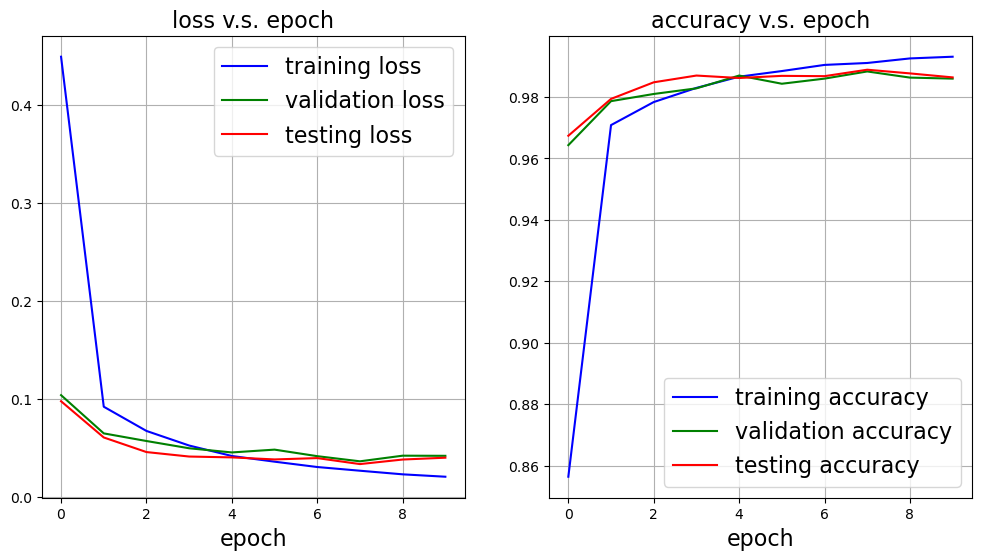

In [17]:
plot_result(loss_train_list, acc_train_list, 
            loss_val_list, acc_val_list,
            loss_test_list, acc_test_list)

In [18]:
#load the best model
best_id= np.argmax(acc_val_list)
best_id

7

In [19]:
from tensorflow.keras.models import load_model
model = load_model('LeNet5_Keras_epoch'+str(best_id)+'.keras')

In [20]:
score = model.evaluate(x_test, y_test, batch_size=64, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03397572785615921
Test accuracy: 0.9889000058174133
